# Basis Pursuit

**Author: M. Ravasi, KAUST**

Welcome to the second exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Learn how to solve a Basis Pursuit problem with PyProximal;
- Compare the performance of different proximal solvers when applied to the same objective function.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyproximal

from pylops import MatrixMult

In [2]:
def callback(x, xtrue, xerr):
    xerr.append(np.linalg.norm(x-xtrue))

## Problem statement

From a mathematical point of view we seek the sparsest solution that satisfies a system of equations.

$$
argmin_\mathbf{x} \|\mathbf{x}\|_1 \; \text{s.t.} \; \mathbf{Gx} = \mathbf{d} \Leftrightarrow argmin_\mathbf{x} \|\mathbf{x}\|_1 + i_{\mathbf{Gx} = \mathbf{d}}
$$

where the operator $\mathbf{G}$ is of size $N \times M$, and generally $N<M$.

Note that this problem is similar to the more general $L_1$ regularized inversion; however, it presents a stricter condition on the data term which must be satisfied exactly. Similarly, we can also consider the Basis Pursuit Denoise problem

$$
argmin_\mathbf{x} \|\mathbf{x}\|_1 \; \text{s.t.} \;  \|\mathbf{Gx} - \mathbf{d}\|_2 < \epsilon \Leftrightarrow argmin_\mathbf{x} \|\mathbf{x}\|_1 + i_{\|\mathbf{Gx} - \mathbf{d}\|_2 < \epsilon}
$$


Let’s start by creating the input vector $\mathbf{x}$, operator $\mathbf{G}$, and data $\mathbf{y}$.

In [3]:
n, m = 40, 100
mava = 10

# model
x = np.zeros(m)
iava = np.random.permutation(np.arange(m))[:mava]
x[iava] = np.random.normal(0, 1, mava)

# operator
G = np.random.normal(0, 1, (n, m))
Gop = MatrixMult(G)

# data
d = Gop * x

We focus now on the Basis Pursuit case and use HQS first

HQS
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = Variable	niter = 150

   Itn       x[0]          f           g       J = f + g
     1  -3.81923e-01   0.000e+00   1.483e+01   1.483e+01
     2  -3.81341e-01   0.000e+00   1.482e+01   1.482e+01
     3  -3.72966e-01   0.000e+00   1.467e+01   1.467e+01
     4  -3.58829e-01   0.000e+00   1.437e+01   1.437e+01
     5  -3.42144e-01   0.000e+00   1.400e+01   1.400e+01
     6  -3.25098e-01   0.000e+00   1.362e+01   1.362e+01
     7  -3.08710e-01   0.000e+00   1.326e+01   1.326e+01
     8  -2.93417e-01   0.000e+00   1.296e+01   1.296e+01
     9  -2.78078e-01   0.000e+00   1.267e+01   1.267e+01
    10  -2.62708e-01   0.000e+00   1.240e+01   1.240e+01
    16  -1.86622e-01   0.000e+00   1.117e+01   1.117e+01
    31  -1.90527e-01   0.000e+00   9.507e+00   9.507e+00
    46  -1.62754e-01   1.000e+00   9.

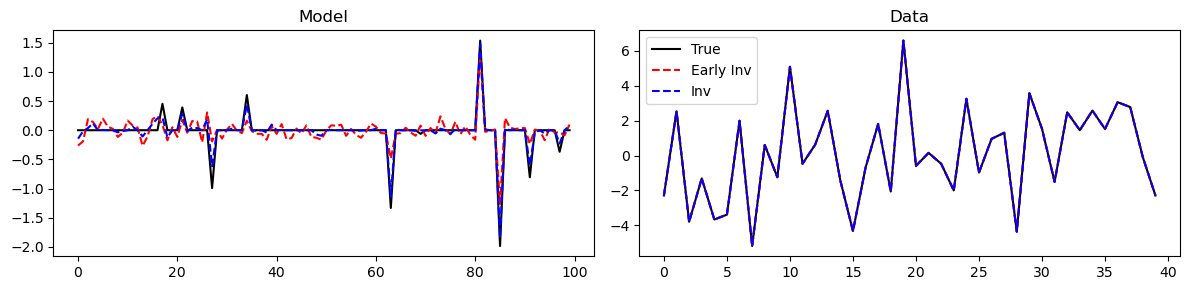

In [4]:
f = pyproximal.AffineSet(Gop, d, niter=20)
g = pyproximal.L1()

tau = 0.9 ** np.arange(150)
xhqs_early = pyproximal.optimization.primal.HQS(f, g, np.zeros_like(x),
                                                tau[:10], niter=10)[0]

xhqs_err = []
xhqs = pyproximal.optimization.primal.HQS(f, g, np.zeros_like(x),
                                          tau, niter=150, show=True,
                                          callback=lambda xest: callback(xest, x, xhqs_err))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xhqs_early, '--r')
axs[0].plot(xhqs, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xhqs_early, '--r', label='Early Inv')
axs[1].plot(Gop * xhqs, '--b', label='Inv')
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

Let's use ADMM now instead

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.000000e-01	niter = 150

   Itn       x[0]          f           g       J = f + g
     1  -3.81923e-01   0.000e+00   1.483e+01   1.483e+01
     2  -4.07906e-01   0.000e+00   1.222e+01   1.222e+01
     3  -3.94201e-01   0.000e+00   1.175e+01   1.175e+01
     4  -3.70500e-01   0.000e+00   1.111e+01   1.111e+01
     5  -3.70730e-01   0.000e+00   1.086e+01   1.086e+01
     6  -3.82852e-01   0.000e+00   1.045e+01   1.045e+01
     7  -3.90288e-01   0.000e+00   1.015e+01   1.015e+01
     8  -3.88285e-01   0.000e+00   1.000e+01   1.000e+01
     9  -3.75715e-01   0.000e+00   9.902e+00   9.902e+00
    10  -3.61033e-01   0.000e+00   9.972e+00   9.972e+00
    16  -2.06888e-01   0.000e+00   9.445e+00   9.445e+00
    31   3.56905e-03   0.000e+00   8.837e+00   8.837e+00
    46  -3.34771e-04   0.000e+00

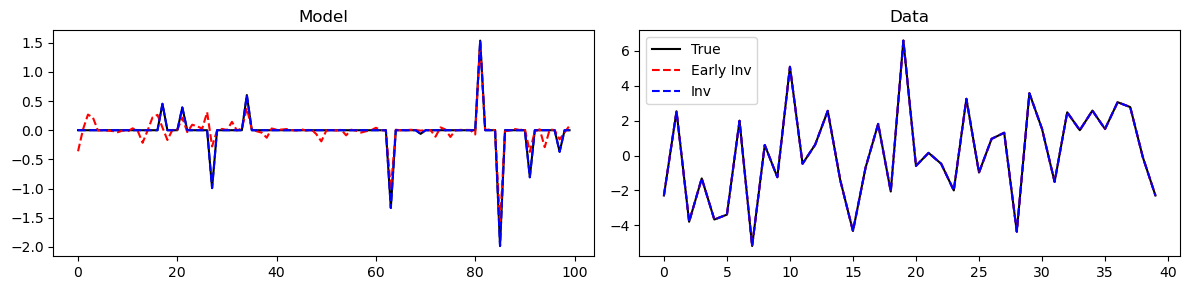

In [5]:
f = pyproximal.AffineSet(Gop, d, niter=20)
g = pyproximal.L1()

xadmm_early = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                                  0.1, niter=10)[0]

xadmm_err = []
xadmm = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                            0.1, niter=150, show=True,
                                            callback=lambda xest: callback(xest, x, xadmm_err))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xadmm_early, '--r')
axs[0].plot(xadmm, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xadmm_early, '--r', label='Early Inv')
axs[1].plot(Gop * xadmm, '--b', label='Inv')
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

And finally we compare the converge behaviour of the two solvers

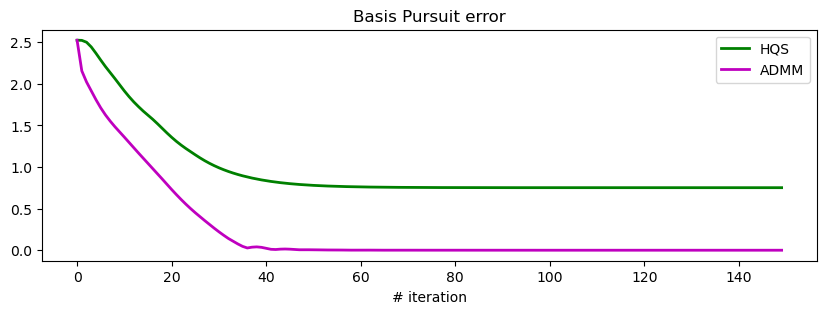

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xhqs_err, "g", lw=2, label="HQS")
ax.plot(xadmm_err, "m", lw=2, label="ADMM")
ax.set_title("Basis Pursuit error")
ax.set_xlabel('# iteration')
ax.legend();

Finally, let's see how we can easily switch to the Basis Pursuit Denoise problem

Epsilon 3.4621074646324796
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.Euclidean.EuclideanBall'>
Linear operator (A): <class 'pylops.basicoperators.matrixmult.MatrixMult'>
Additional vector (z): None
tau = 0.99		mu = 0.003975870471692683
theta = 1.00		niter = 150

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1  -0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     2  -0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     3  -0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     4  -0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     5  -0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     6  -0.00000e+00   1.880e-01   0.000e+00   0.000e+00       1.880e-01
     7  -0.00000e+00   5.146e-01   0.000e+00   0.000e+00 

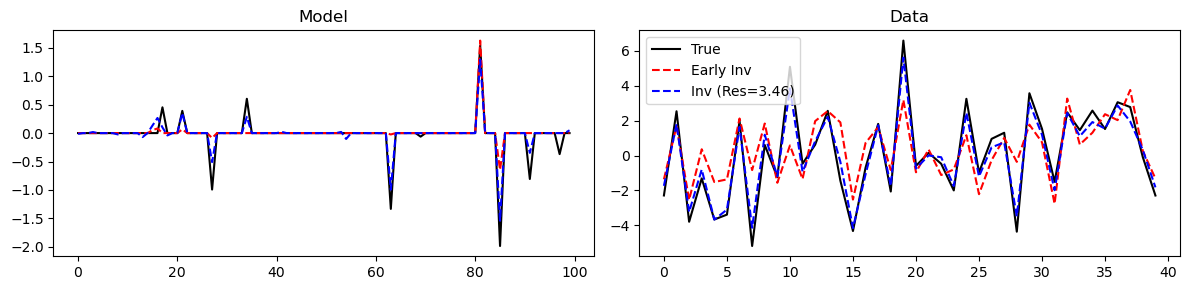

In [21]:
# Add noise to data and estimate eps for Euclidean Ball
n = np.random.normal(0, .5, d.size)
dn = d + n
eps = np.linalg.norm(dn - d)
print('Epsilon', eps)

f = pyproximal.L1()
g = pyproximal.proximal.EuclideanBall(d, eps)

L = np.real((Gop.H @ Gop).eigs(1))[0]
tau = .99
mu = tau / L

xpd_early = pyproximal.optimization.primaldual.PrimalDual(f, g, Gop, np.zeros_like(x),
                                                           tau, mu, niter=10)

xpd_err = []
xpd = pyproximal.optimization.primaldual.PrimalDual(f, g, Gop, np.zeros_like(x),
                                                    tau, mu, niter=150, show=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xpd_early, '--r')
axs[0].plot(xpd, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xpd_early, '--r', label='Early Inv')
axs[1].plot(Gop * xpd, '--b', label='Inv (Res=%.2f)' % np.linalg.norm(d - Gop @ xpd))
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

## Recap

In this tutorial we have learned to:

- How to set up the Basis Pursuit and Basis Pursuit Denoise problems in PyProximal;
- How to compare different optimizers (and use callbacks to track the converge behaviour of different solutions).